# The Plan

**1. Dataset Acquisition & Understanding**

- **Download the CHBM-MIT EEG dataset:** Go to [https://physionet.org/content/chbmit/](https://physionet.org/content/chbmit/) and follow the instructions to download the dataset.
- **Familiarize yourself with the data:**
  - Open the downloaded files in a text editor or use data exploration tools in Python like pandas.
  - Identify the format of the data (e.g., EDF, CSV).
  - Understand the channels, sampling rate, and meaning of each column in the data.
  - Explore the provided annotation files and seizure labels.
- **Choose environment:**
  - **Macbook Air M1:** Install Python (version 3.7 or above) and the necessary libraries (see **Step 4**) using tools like `pip` or `homebrew`.
  - **Google Colab:** No installation needed, access Colab notebooks through [https://research.google.com/colaboratory/](https://research.google.com/colaboratory/) and import the libraries directly in the notebook.

**2. Preprocessing & Feature Extraction**

- **Import libraries:**

```python
import mne
import numpy as np
import matplotlib.pyplot as plt
```

- **Load data:** Use mne functions like `mne.io.read_raw_edf` to load the EEG data.

```python
raw = mne.io.read_raw_edf('chb01_01.edf', preload=False)  # Replace with your filename
```

- **Cleaning and Filtering:**
  - Apply basic filtering (e.g., notch filter to remove power line noise) using `raw.filter()`.
  - Perform visual inspection (e.g., plotting the data) to identify and remove artifacts like muscle movement or equipment noise.
  - Learn about advanced cleaning techniques like Independent Component Analysis (ICA) for advanced noise reduction.
- **Resampling:**
  - If needed, resample the data to a consistent sampling rate using `raw.resample()`
- **Segmentation:**
  - Use event markers or annotations to segment the data into relevant epochs (e.g., ictal and interictal periods) using `mne.Epochs`.
  - Consider different epoch lengths based on your chosen features and seizure type.
- **Feature Extraction:**
  - Implement functions to calculate desired time-domain features (e.g., mean, variance, amplitude) and frequency-domain features (e.g., power spectral density using FFT) using libraries like NumPy or scikit-learn.
  - Explore libraries like NeuroKit2 for specific EEG feature extraction functionalities.
  - Consider advanced features like connectivity metrics (coherence, phase lag) using MNE-Python for later source localization.

**3. Binary Classification**

- **Data splitting:** Use scikit-learn's functions (e.g., `train_test_split`) to split your labeled data (epileptic vs. non-epileptic) into training (60%), validation (20%), and testing (20%) sets.
- **Model selection:**
  - **Start simple:**
    - **Logistic Regression:**
      ```python
      from sklearn.linear_model import LogisticRegression
      model = LogisticRegression(solver='lbfgs')
      model.fit(X_train, y_train)  # X_train and y_train are your training data and labels
      ```
    - **Support Vector Machine (SVM):**
      ```python
      from sklearn.svm import SVC
      model = SVC(kernel='linear')
      model.fit(X_train, y_train)
      ```
  - **Explore neural networks if needed:**
    - **Convolutional Neural Networks (CNNs):** Learn about building and training CNNs for time-series data using PyTorch tutorials and examples.
    - **Long Short-Term Memory (LSTM) networks:** Explore LSTMs for capturing temporal dependencies in EEG data if applicable.
- **Training:** Use PyTorch's functionalities to train your chosen model on the training data. Set up a training loop with loss function (e.g., binary cross-entropy), optimizer (e.g., Adam), and training epochs.

```python
# Example training loop for Logistic Regression
import torch
from torch import nn

# ... define your model and data loaders

criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epochs):
    # Train the model
    # ...
```

# Dataset

## Description of CHBM-MIT EEG Dataset
### Dataset: Scalp EEG Recordings from Children with Intractable Seizures

This dataset contains electroencephalography (EEG) recordings from **22 subjects** with intractable seizures. The data is grouped into **23 cases**, with some subjects contributing multiple recordings.

**Key Points:**

* **Subjects:** 22 (5 males, 17 females; ages 1.5-22)
* **Cases:** 23 (chb01 to chb23)
* **Sampling Frequency:** 256 Hz
* **Recordings per Subject:** 9-42 (each lasting 1-4 hours)
* **Seizures:** 198 total (182 in original set)
* **File Types:**
    * `.edf`: Raw EEG data files (664 total)
    * `.seizure`: Annotations for seizure start and end times (for files containing seizures)

**Additional Notes:**

* Case `chb21` is from the same subject as `chb01`, but recorded 1.5 years later.
* Case `chb24` is not included in the `SUBJECT-INFO` file.

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

LOCAL_PATH = os.getenv("LOCAL_PATH")

In [3]:
from glob import glob
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load paths

In [4]:
#? Load the data from the records.txt file
records_txt = LOCAL_PATH + 'RECORDS'
with open(records_txt, 'r') as file:
    records_path = [LOCAL_PATH + line.strip() for line in file]
print(len(records_path), records_path)

#? Load the data from the records-with-seizures.txt file
records_seizure_txt = LOCAL_PATH + 'RECORDS-WITH-SEIZURES'
with open(records_seizure_txt, 'r') as file:
    records_seizure_path = [LOCAL_PATH + line.strip() for line in file]
print(len(records_seizure_path), records_seizure_path)

#? Get the records that are not in the records-with-seizures.txt file
records_seizure_set = set(records_seizure_path) #* Convert records_seizure_path to a set for faster lookup
records_normal_path = [record for record in records_path if record not in records_seizure_set]
print(len(records_normal_path), records_normal_path)

686 ['/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_01.edf', '/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_02.edf', '/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf', '/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_04.edf', '/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_05.edf', '/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_06.edf', '/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_07.edf', '/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_08.edf', '/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_09.edf', '/Users/aaryaa

### edf -> numpy array

In [5]:
#? Convert the edf files to a numpy array
def read_edf(file):
    data = mne.io.read_raw_edf(file, preload=True) #* Load the data
    data.set_eeg_reference() #* Set the reference to the average of the channels
    data.filter(l_freq=0.5, h_freq=45) #* Filter the data to remove noise and artifacts and to get the frequency band of interest (0.5-45Hz)
    epoch = mne.make_fixed_length_epochs(data, duration=5, overlap=2) #* Create epochs of 5 seconds with 2 seconds overlap, to get the data in a format that can be used for training
    data = epoch.get_data() #* Convert the data to a numpy array
    return data

In [29]:
%%capture
raw = mne.io.read_raw_edf(records_path[0])

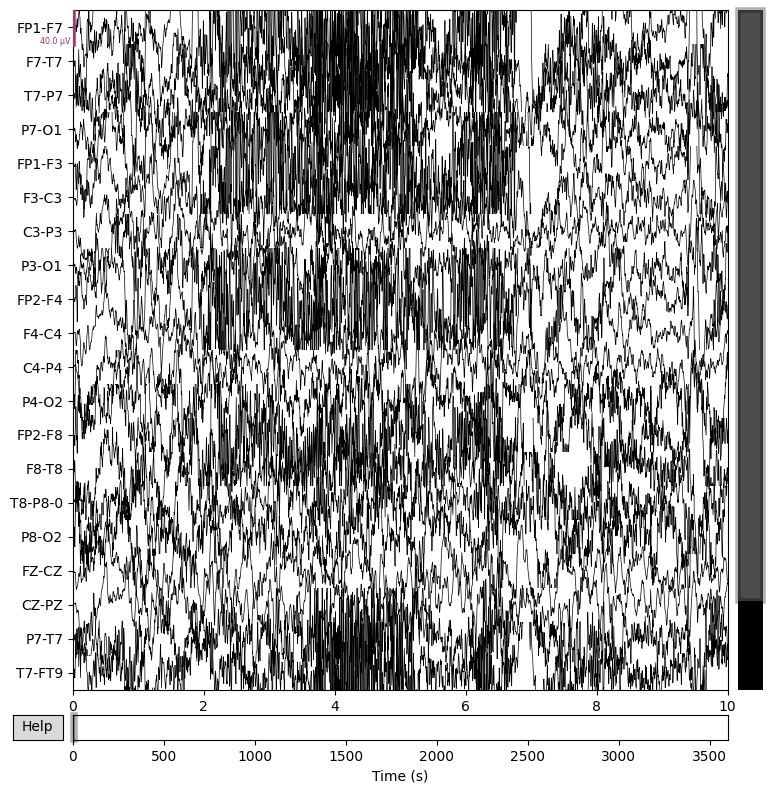

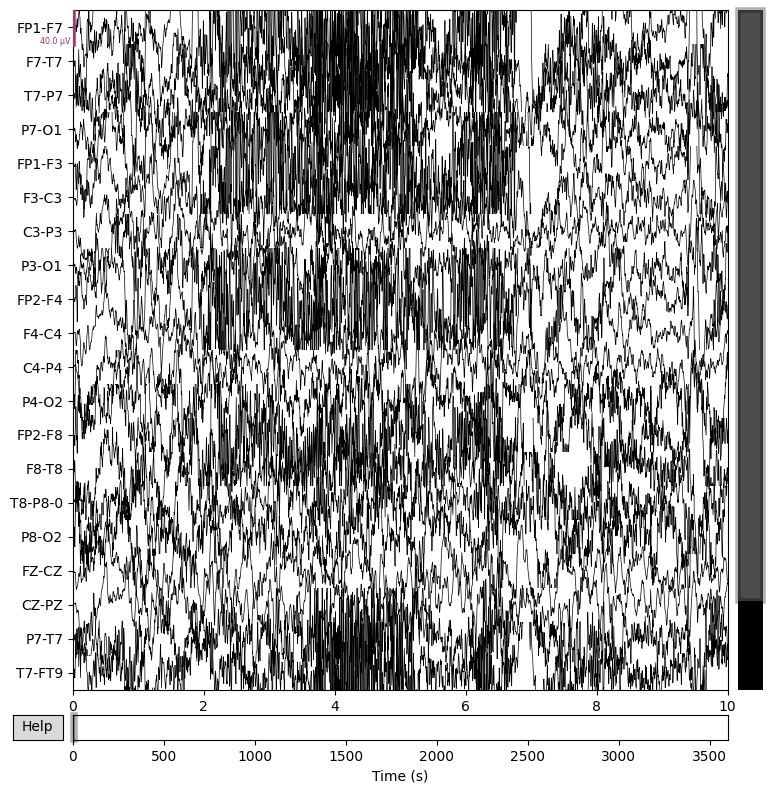

In [30]:
raw.plot()

In [6]:
%%capture
test = read_edf(records_path[0])

In [7]:
print(test.shape)

(1199, 23, 1280)


In [11]:
#* Create Labels
normal_labels = np.zeros(len(records_normal_path))
seizure_labels = np.ones(len(records_seizure_path))
labels = np.concatenate((normal_labels, seizure_labels))
print(seizure_labels.shape, normal_labels.shape, labels.shape)

(142,) (545,) (687,)


In [42]:
normal_path_labels = np.array(list(zip(records_normal_path, normal_labels)))
seizure_path_labels = np.array(list(zip(records_seizure_path, seizure_labels)))
path_labels = np.concatenate((normal_path_labels, seizure_path_labels))
print(seizure_path_labels[:5])
print(normal_path_labels[:5])

[['/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf'
  '1.0']
 ['/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_04.edf'
  '1.0']
 ['/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_15.edf'
  '1.0']
 ['/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_16.edf'
  '1.0']
 ['/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_18.edf'
  '1.0']]
[['/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_01.edf'
  '0.0']
 ['/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_02.edf'
  '0.0']
 ['/Users/aaryaashokk/Documents/Coding/Projects/DataSets/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_05.edf'
  '0.0']
 ['/Users/aaryaashokk/Documents/Coding/Projects

# Model

Testing and training sets<br>
Total Normal = 545<br>
Total Seizure = 142<br>
So we can use around 75% of this data for training ang remaining 25% for testing<br>
We can use 75% of the data for training (normal 410, seizure 105) and 25% for testing (normal 135, seizure 42)<br>

## Neural Network